# Train Model Notebook

This notebook will help us in achieving the followings:

* Visualisation Of The Data Before Splitting
* Setting Up The Dataset By Splitting The Data Into Train, Val and Test Set.
* Check And Visualise The Data Present In The Train, Val and Test Directory After Splitting Along With The Mask Files.
* Create The Image Data Generator Object And The Then Visualise The Data From The Object
* Create The Model Using The Segmentation Model Package To Test The Training If It Works.
* After The Completion Of The Training, It Helps In Generating The Inference With Them IOU And Accuracy Metric Score Along With Its Visualisation Against The Original Raster File And The Actual Mask File
* Visualise The Saved Inference.

## Requirements

This notebook requires the following thing in order to proceed:

* Raster Files must be converted into jpg format. This task can be achieved by using the **tiff2jpg** notebook.
  
* Manuall Annotated ShapeFiles must be rasterise into tif files. This task can be achieved by using the **Converting_Shapefiles_Into_A_Binary_Raster** notebook.
  

In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np
# import geojson
import dask
import os
import ntpath
from pathlib import Path

import tensorflow as tf
import matplotlib.gridspec as gridspec

from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose

import cv2
import glob
import json
import numpy as np
import rasterio

from datetime import datetime
from functools import partial
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from skimage import filters

from skimage.io import imsave, imread

Using TensorFlow backend.


In [2]:
tf.__version__


'1.13.1'

In [3]:
import keras

from segmentation_models import Unet
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# import model
# add helper function location
import sys 
sys.path.append('../functions')

from helpers import *
from data import *

Segmentation Models: using `keras` framework.


# Visualise the data before splitting

In [4]:
import tifffile as tiff
from PIL import Image
import glob

mask_files_path = '../data/mask_files/*.tif'
raster_files = '../data/nir_green_blue/images/*.jpg'
raster = glob.glob(raster_files)
actual = glob.glob(mask_files_path)


In [5]:
actual[0:10]

['../data/mask_files/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif',
 '../data/mask_files/Denpasar_039_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif',
 '../data/mask_files/Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif',
 '../data/mask_files/Jakarta_254_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif',
 '../data/mask_files/Jakarta_230_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif',
 '../data/mask_files/Cilegon_004_pansharpen_True_2016-08-06_03:21_1030010059856700_05-18-2020_08:55:26.tif',
 '../data/mask_files/Jakarta_340_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif',
 '../data/mask_files/Jakarta_255_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.tif',
 '../data/mask_files/Jakarta_597_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif',
 '../data/mask_fi

In [6]:
# add base data to dataset

base_data_mask_path = '../data/mask_files/*.tif'
base_data_mask_paths = glob.glob(base_data_mask_path)

len(base_data_mask_paths), len(mask_files_path)

base_data_mask_paths[0].replace('mask_files', 'nir_green_blue/image').replace('tif','jpg')

'../data/nir_green_blue/image/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.jpg'

# Split the Dataset Into Train, Val and Test Set

In [7]:
from sklearn.model_selection import train_test_split

# jpg_files = '/home/ubuntu/sukh_share/water_detection_model/rgb/jpg_raster_files/*.jpg'
mask_files = '../data/mask_files/*.tif'

# jpg_files = glob.glob(raster_files)
mask_files_path = glob.glob(mask_files)

data = list(mask_files_path)

if True:
    data = np.hstack([base_data_mask_paths, data])

print(data[0])
train, val = train_test_split(data, test_size=0.2, shuffle = False)
val, test = train_test_split(val, test_size=0.2, shuffle = False)
# print(len(train))
# print(len(test))
# print(len(val))

# Copy the files to the expected dataset location
from shutil import copyfile, copy2, rmtree
dst = '../data/nir_green_blue/train'
dst_mask = '../data/nir_green_blue/train_mask'

try:
    os.mkdir(dst)
    os.mkdir(dst_mask)
except:
    print('folder already exists')

# remove all the files inside the destination and destination mask folder
for f in glob.glob(dst + '/*'):
    os.remove(f)
for f in glob.glob(dst_mask + '/*'):
    os.remove(f)
    
for mask_file in train:
    
    file_name = ntpath.basename(mask_file)
    root_path = str(Path(mask_file).parent).replace('mask_files','nir_green_blue/images')
    root_path = root_path.replace('mask_files', 'images')
    raster_file = os.path.join(root_path, file_name.replace('tif','jpg'))
    
    copy2(raster_file, dst)
    copy2(mask_file, dst_mask)

dst = '../data/nir_green_blue/val'
dst_mask = '../data/nir_green_blue/val_mask'
try:
    os.mkdir(dst)
    os.mkdir(dst_mask)
except:
    print('folder already exists')

# remove all the files inside the destination and destination mask folder
for f in glob.glob(dst + '/*'):
    os.remove(f)
for f in glob.glob(dst_mask + '/*'):
    os.remove(f)
    
for mask_file in val:
    
    file_name = ntpath.basename(mask_file)
    root_path = str(Path(mask_file).parent).replace('mask_files','nir_green_blue/images')
    root_path = root_path.replace('mask_files', 'images')
    raster_file = os.path.join(root_path, file_name.replace('tif','jpg'))
    
    copy2(raster_file, dst)
    copy2(mask_file, dst_mask)

dst = '../data/nir_green_blue/test'
dst_mask = '../data/nir_green_blue/test_mask'
try:
    os.mkdir(dst)
    os.mkdir(dst_mask)
except:
    print('folder already exists')

# remove all the files inside the destination and destination mask folder
for f in glob.glob(dst + '/*'):
    os.remove(f)
for f in glob.glob(dst_mask + '/*'):
    os.remove(f)
    
for mask_file in test:
    
    file_name = ntpath.basename(mask_file)
    root_path = str(Path(mask_file).parent).replace('mask_files','nir_green_blue/images')
    root_path = root_path.replace('mask_files', 'images')
    raster_file = os.path.join(root_path, file_name.replace('tif','jpg'))
    
    copy2(raster_file, dst)
    copy2(mask_file, dst_mask)

../data/mask_files/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
folder already exists
folder already exists
folder already exists


# Check and Visualise the data present in the train and val folder after splitting

In [8]:
import tifffile as tiff
from PIL import Image
import glob
raster = glob.glob('../data/nir_green_blue/val/*.jpg')
actual = glob.glob('../data/nir_green_blue/val_mask/*.tif')

# for file in raster[0:3]:
#     filename = ntpath.basename(file)
    
#     plt.figure(figsize=(20,20))
    
#     # The original raster file
#     plt.subplot(131)
#     plt.imshow(Image.open(file), cmap = 'Greens')
    
#     base_path = str(Path(file).parent)
#     base_path = base_path.replace('val', 'val_mask')
    
#     # The actual mask file
#     plt.subplot(132)
#     plt.imshow(Image.open(os.path.join(base_path, filename.replace('jpg','tif'))), cmap = 'Greens')
    

# Train With Data Generator

In [9]:
from data import *
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
batch=8
data_path='../data/nir_green_blue'
train_raster_file_folder_name='train'
train_mask_file_folder_name='train_mask'
val_raster_file_folder_name='val'
val_mask_file_folder_name='val_mask'
image_color_mode='rgb'
mask_color_mode='rgb'

myGene_train = trainGenerator(batch,
                              data_path,
                              train_raster_file_folder_name,
                              train_mask_file_folder_name,
                              data_gen_args,
                              image_color_mode =image_color_mode, 
                              mask_color_mode = mask_color_mode, 
                              save_to_dir = None)

myGene_val = trainGenerator(batch,
                            data_path, 
                            val_raster_file_folder_name, 
                            val_mask_file_folder_name,
                            data_gen_args,
                            image_color_mode =image_color_mode, 
                            mask_color_mode = mask_color_mode, 
                            save_to_dir = None)

# Visualise the Image From Data Generator

In [ ]:
import tifffile as tiff
count = 0 
for raster, mask in myGene_train:
    count+=1
    print(raster.shape)
    print(mask.shape)
    tiff.imshow(raster)
    tiff.imshow(mask)
    if count ==5:
        break

# Create The Model Using Package Segmentation Model To Test The Training If It Works

In [10]:
from segmentation_models import Unet
from keras.layers import Input, Conv2D
from keras.models import Model

# define number of channels
N = 3

# Import The Base Model 
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

# Create The Input Layer For the model based on our input shape of the image
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

# Compile The Model
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(opt, loss=bce_jaccard_loss, metrics=[iou_score,'accuracy'])


In [12]:
weights_path = '../models/weights'
log_path = '../data/models/log/'

make_dir(log_path)

# m = model
model.summary()
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(os.path.join(weights_path,filepath), 
                             monitor='val_iou_score', verbose=1, 
                             save_best_only=True, mode='max')

csv_logger = CSVLogger(log_path + 'log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'iou_score', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]

results = model.fit_generator(myGene_train,steps_per_epoch=2000, validation_data=myGene_val, 
                              validation_steps=500, use_multiprocessing=False, 
                              epochs=5,callbacks=callbacks_list)
model.save('Model_unet_batch_8_version_0.h5')

Directory  ../data/models/log/  already exists...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 3)     12        
_________________________________________________________________
model_2 (Model)              (None, None, None, 1)     24456154  
Total params: 24,456,166
Trainable params: 24,438,816
Non-trainable params: 17,350
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
Found 43 images belonging to 1 classes.
Found 134 images belonging to 1 classes.
Found 43 images belonging to 1 classes.
Found 134 images belonging to 1 classes.
   1/2000 [..............................] - ETA: 26:34:43 - loss: 1.7182 - iou_score: 0.1825 - acc: 0.3492

KeyboardInterrupt: 

# Create the model for testing

In [4]:
from segmentation_models.metrics import iou_score
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from keras.optimizers import Adam

N = 3

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.load_weights("/home/ubuntu/sukh_share/water_detection_model/NIR_Green_Blue/model_weights/Model_unet_1.h5")

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(opt, loss=bce_jaccard_loss, metrics=[iou_score,'accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
print(model.metrics_names)

['loss', 'iou_score', 'acc']


# Save The Results Using the filename | Alternative of test data generator

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


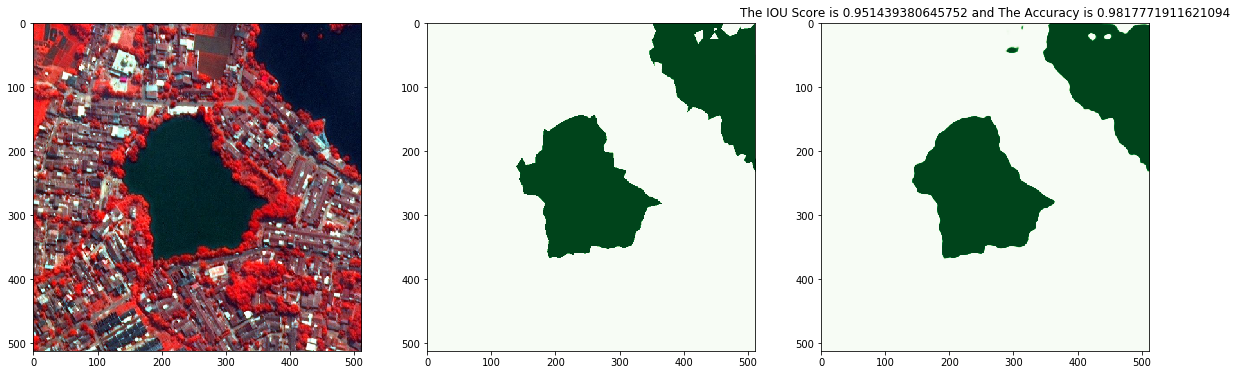

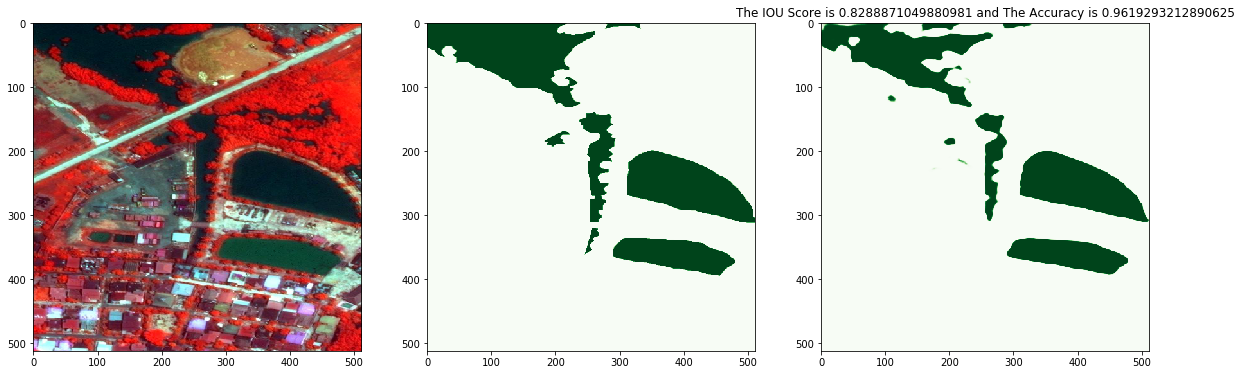

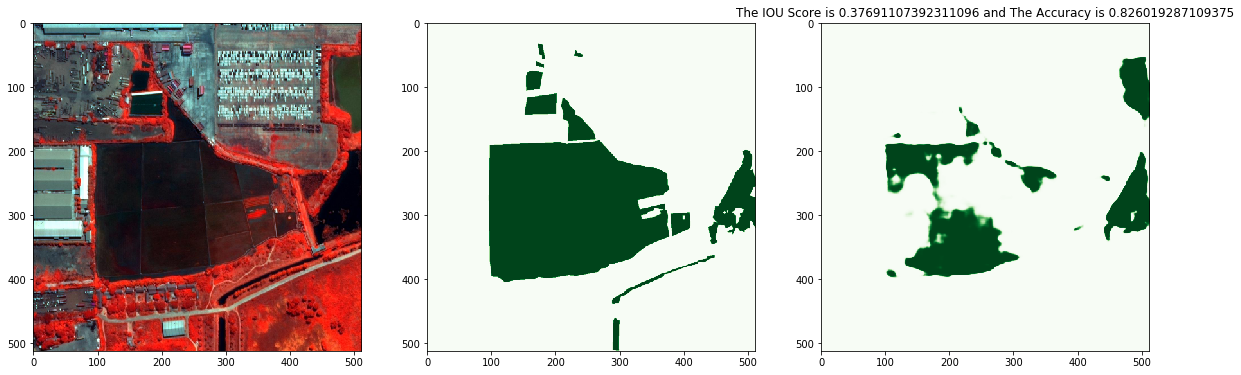

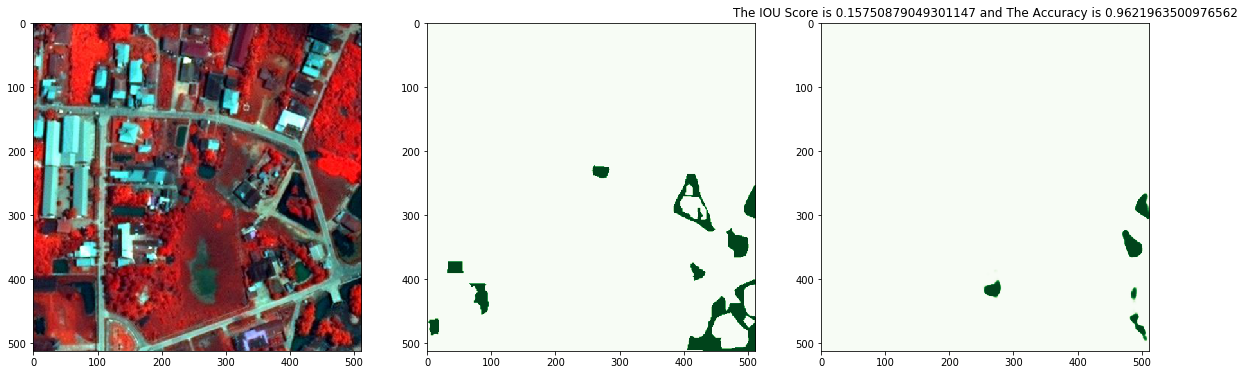

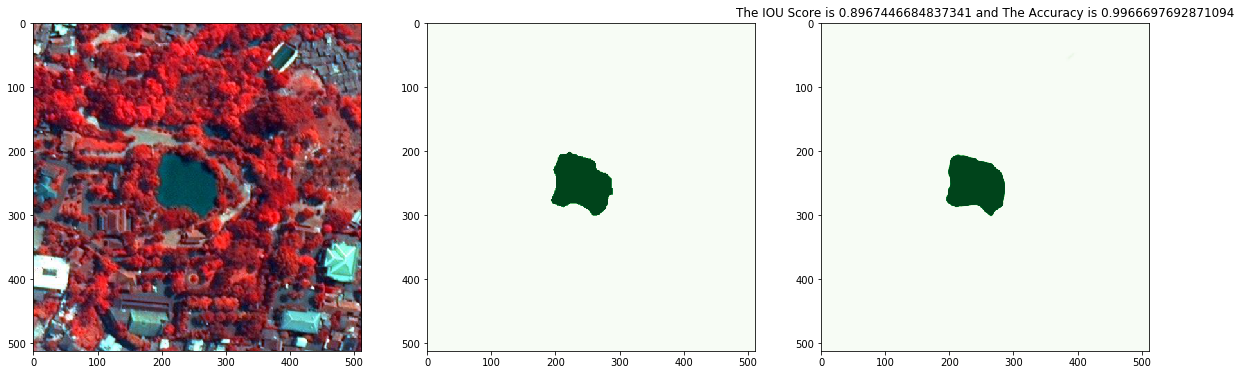

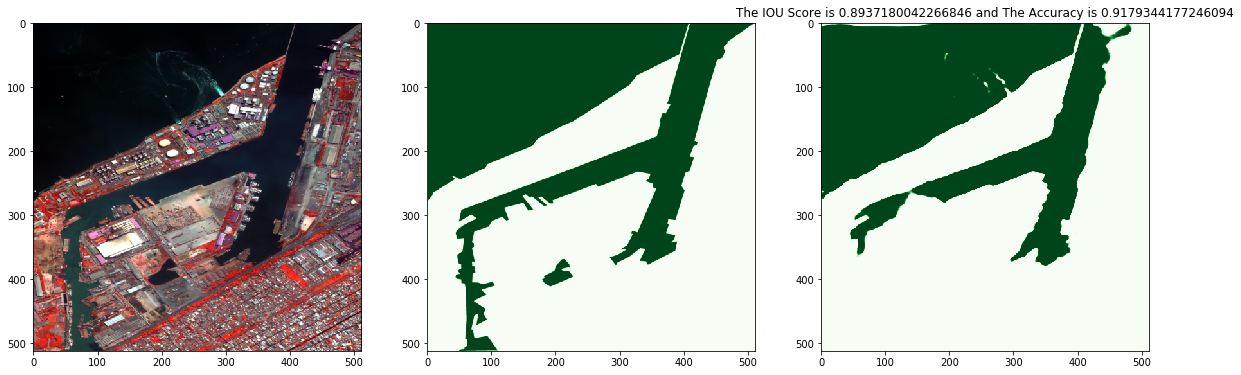

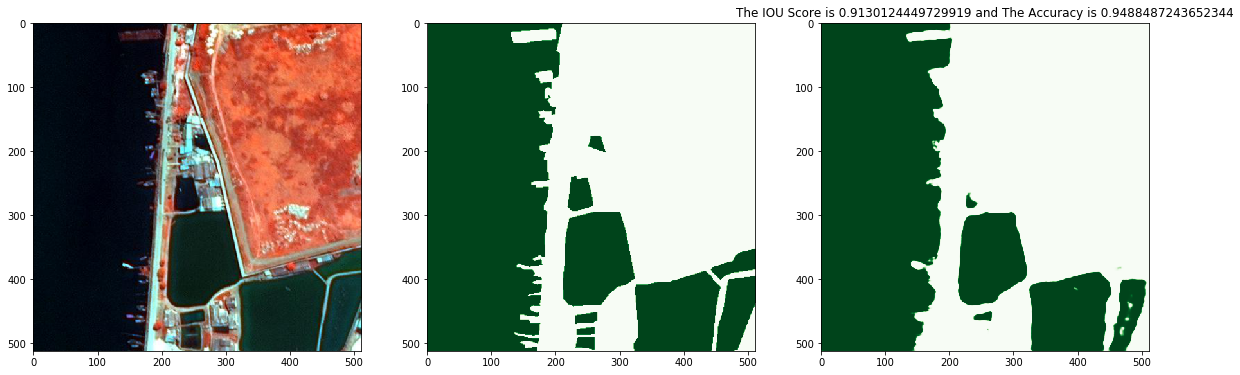

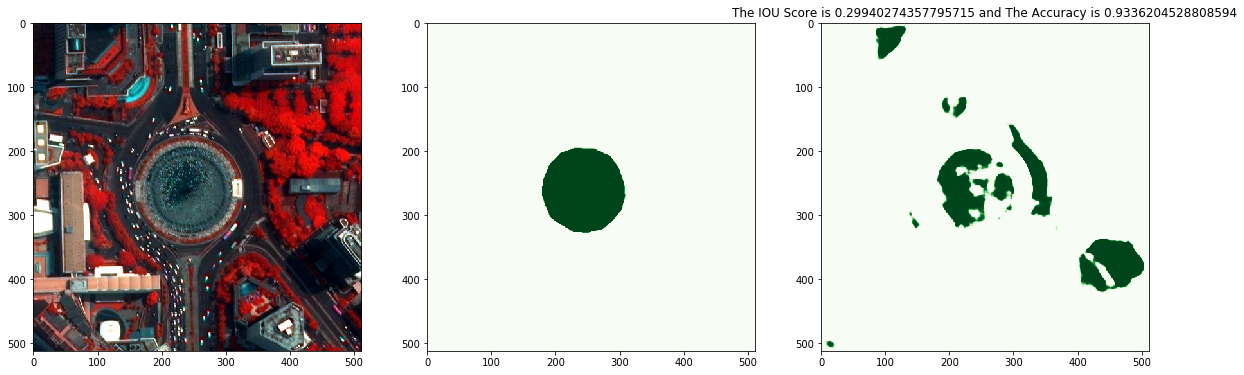

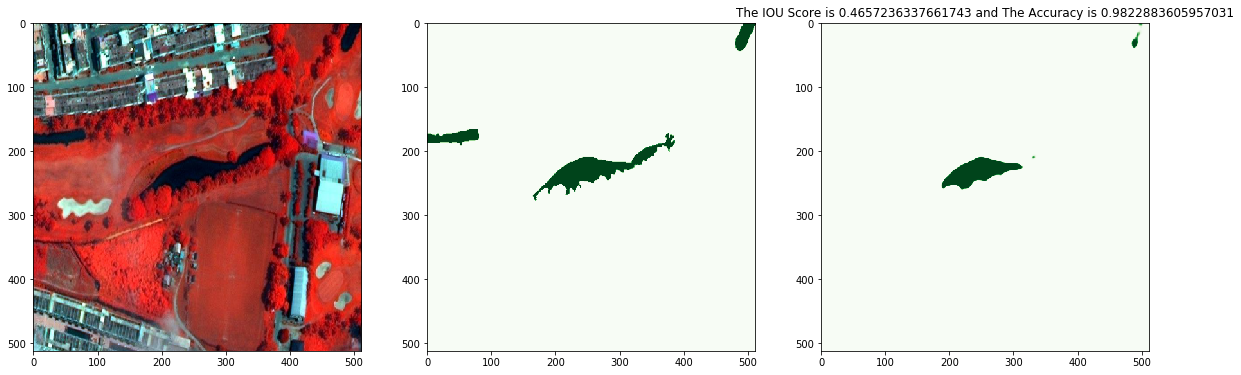

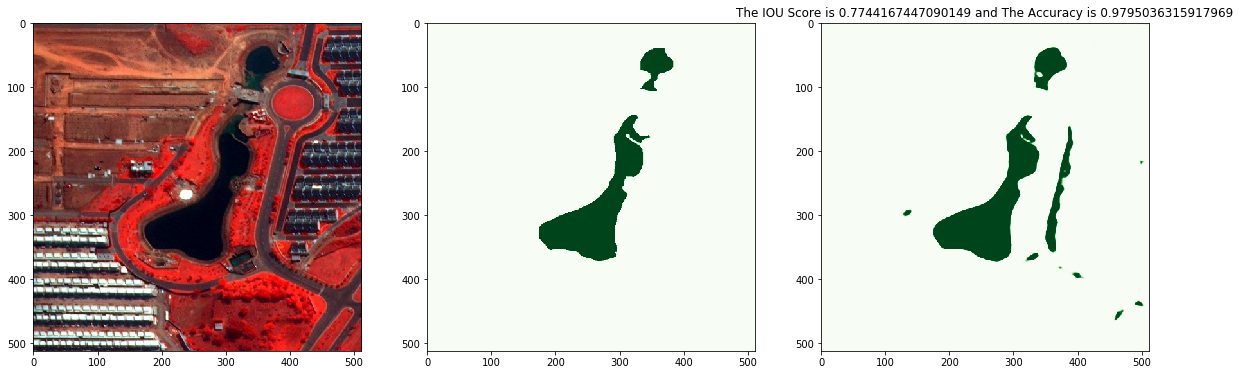

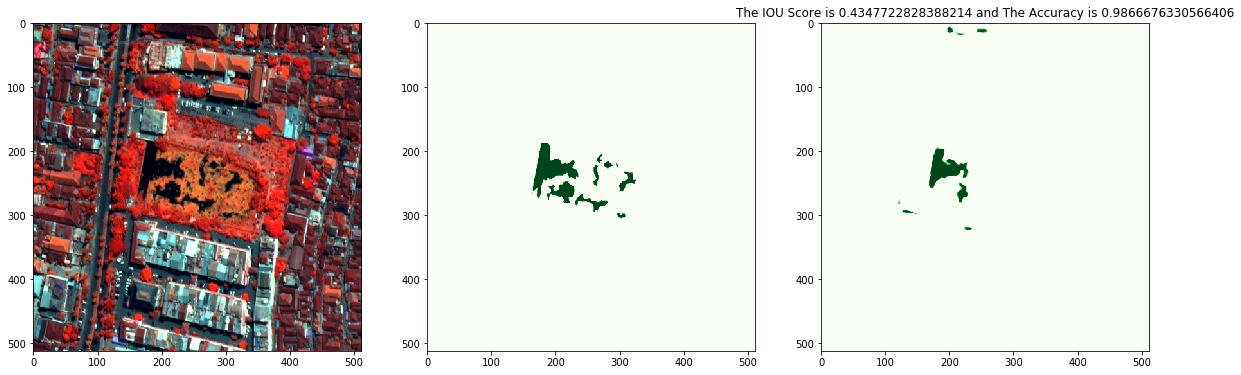

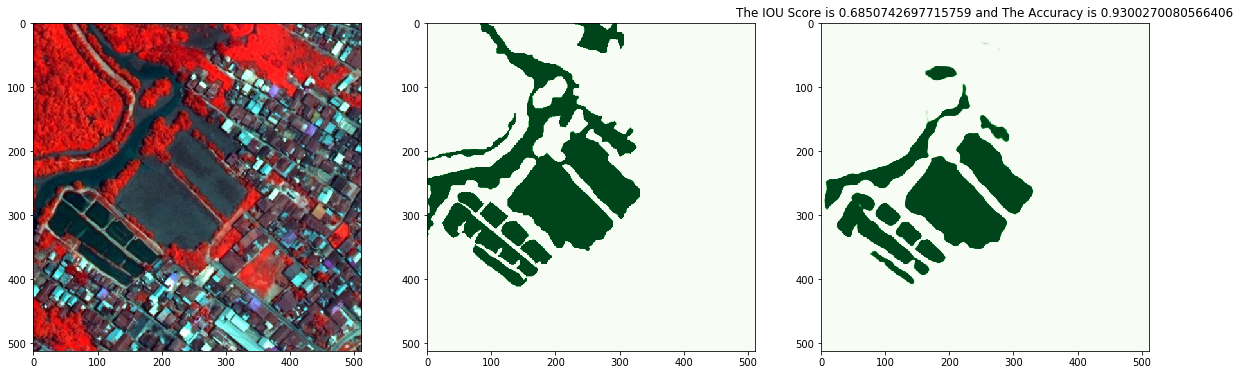

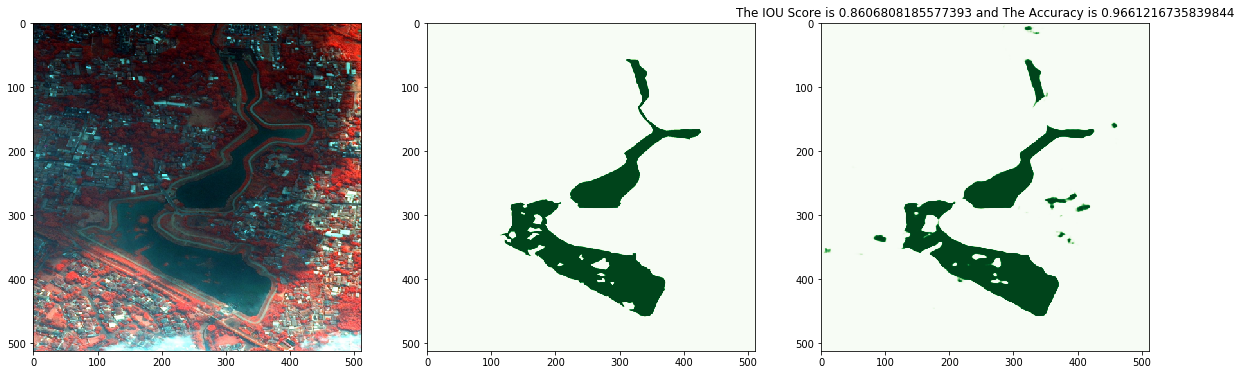

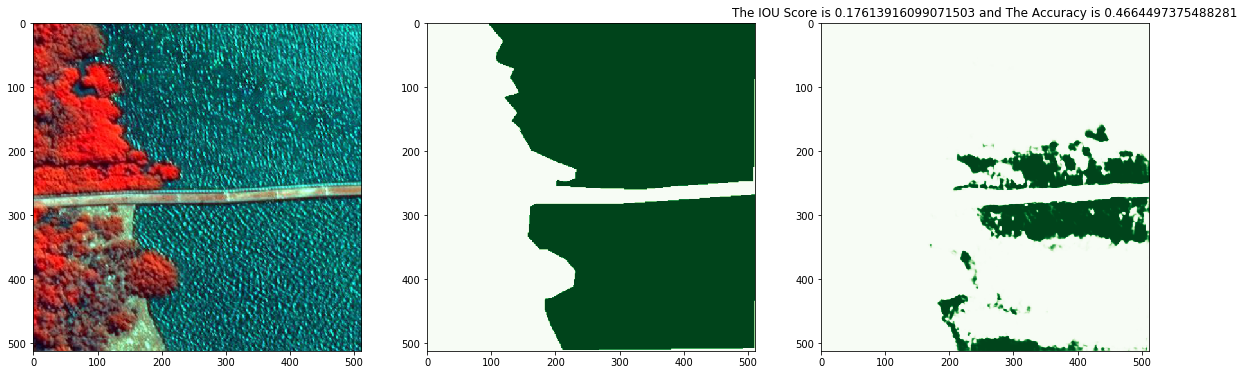

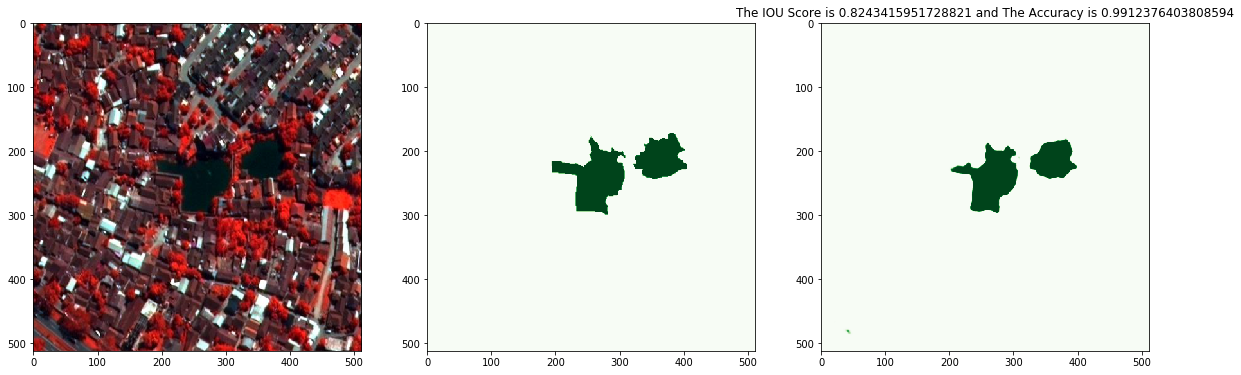

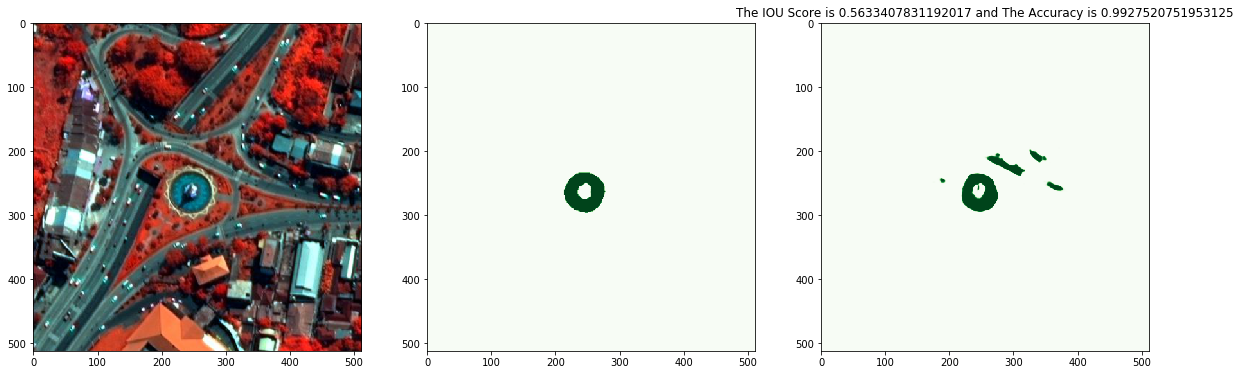

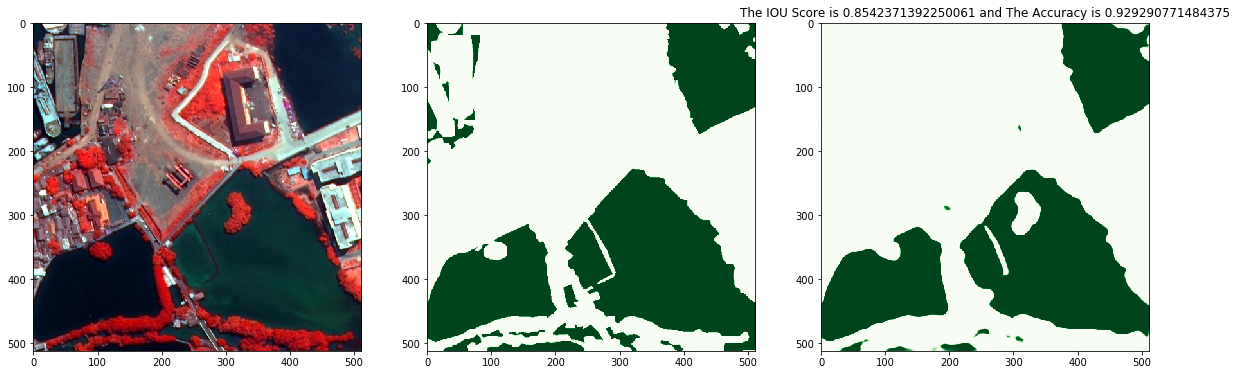

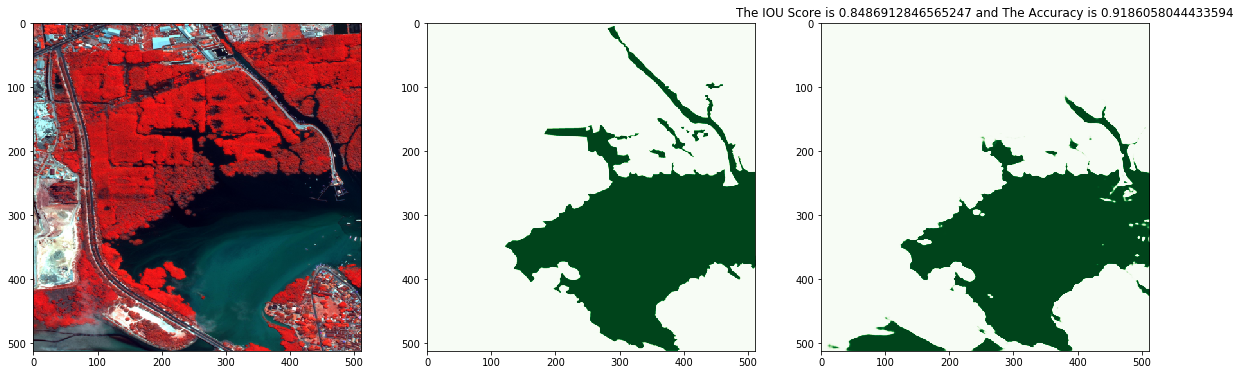

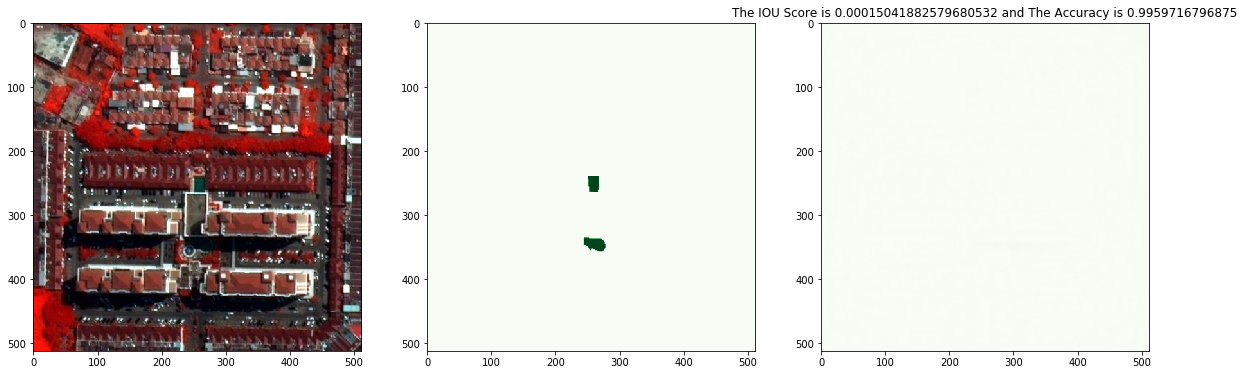

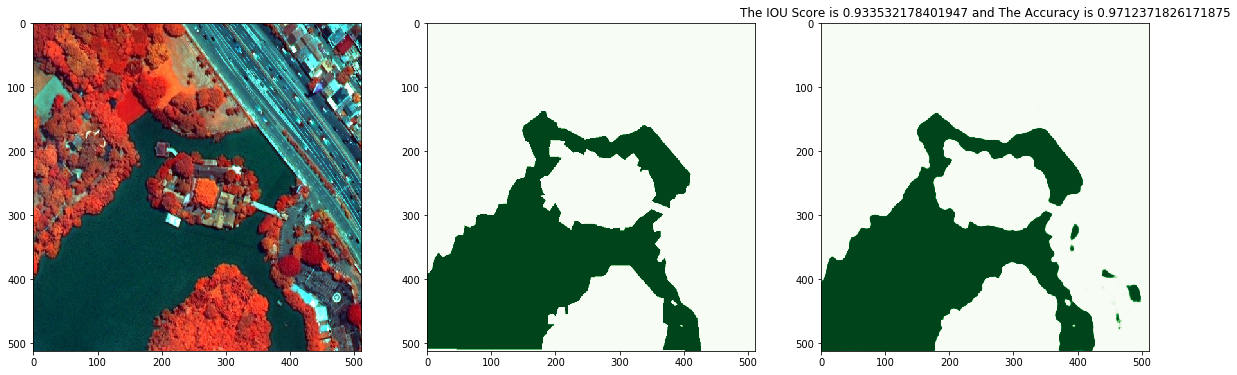

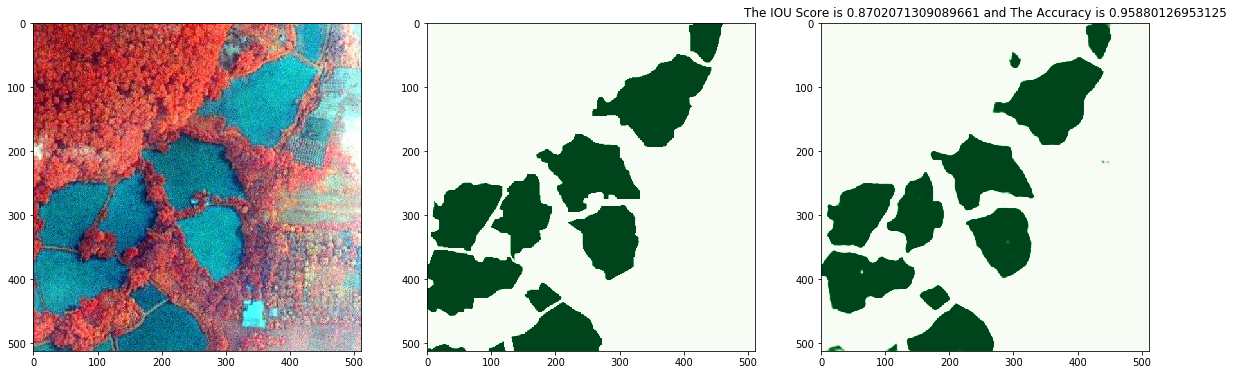

In [7]:
from PIL import Image
import numpy as np
from skimage import transform

iou_score = list()
accuracy_score = list()

def load(filename, input_shape=None):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, input_shape)
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

# Specify the path for testing directory
test_raster_files = '../data/nir_green_blue/val/*.jpg'

raster_file_base_path = '../data/source_data/raster_files'

for file in glob.glob(test_raster_files):
    filename = ntpath.basename(file)
    base_path = str(Path(file).parent)
    image = load(file, (512,512,3))
    mask_file = file.replace('val','val_mask')
    mask_file = mask_file.replace('jpg','tif')
    mask_image = load(mask_file, (512,512,1))
    
    # Getting The Prediction
    result = model.predict(image)
    result = result[0]
    
    # Getting The Evaluation Metric Score
    current_score = model.evaluate(image, mask_image, verbose=0)
    iou = current_score[1]
    accuracy = current_score[2]
    iou_score.append(iou)
    accuracy_score.append(accuracy)
    
    # get the transform and save the file
    raster_file = os.path.join(raster_file_base_path, filename.replace('jpg','tif'))
    dataset = rasterio.open(raster_file)
    profile = dataset.profile
    profile.update(count=1, compress='lzw')
    
    transform_p = dataset.meta['transform']
    
    classification_filename = os.path.join(base_path.replace('val', 'results/val'), filename.replace('jpg','tif'))
    
    # resize the result 
    result = reshape(result[:,:,0])
    
    # write the file
    with rasterio.open(
            classification_filename,
            'w',
            **profile
        ) as dst:
            dst.write(result)
    
    # Visualisation And Comparison
    plt.figure(figsize=(20,20))
    
    # The original raster file
    plt.subplot(131)
    plt.imshow(image[0,:,:,:])
    
    # The actual mask file
    plt.subplot(132)
    plt.imshow(mask_image[0,:,:,0], cmap = 'Greens')
    
    # The predicted mask file
    ax = plt.subplot(133)
    plt.imshow(result[0,:,:], cmap = 'Greens')
    ax.set_title("The IOU Score is {0} and The Accuracy is {1}".format(iou, accuracy))
    
    
#     res_img = result[0,:,:,0]
#     res_img = res_img / 255
#     io.imsave(os.path.join(base_path.replace('test', 'results'), filename.replace('jpg','tif')),res_img)
